In [ ]:
# Load dataset
import pandas as pd
df = pd.read_excel('/content/data_news.xlsx')

# Drop duplicates and nulls
df.drop_duplicates(inplace=True)
df.dropna(subset=['short_description', 'category'], inplace=True)
df.head()


,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


## Text Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['short_description'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Feature Extraction

/tmp/ipython-input-3-2768290084.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=df, palette='Set2')


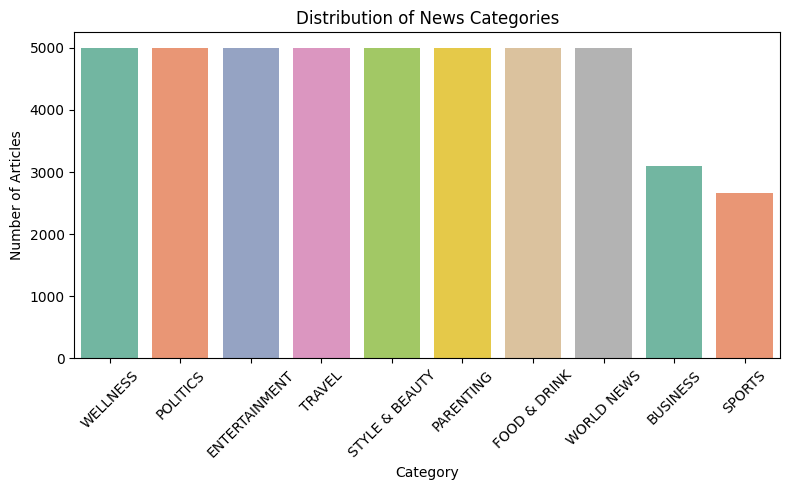

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='category', data=df, palette='Set2')
plt.title("Distribution of News Categories")
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Preprocessing for Word2Vec

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_tokens(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

# Tokenized text for Word2Vec
df['tokens'] = df['short_description'].apply(preprocess_tokens)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Train Word2Vec Embeddings

In [ ]:
!pip uninstall -y numpy gensim
!pip install numpy gensim
from gensim.models import Word2Vec

# Word2Vec expects a list of token lists
sentences = df['tokens'].tolist()

# Train Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 

In [ ]:
# Most similar words to a sample word
w2v_model.wv.most_similar('government', topn=5)


[('security', 0.9942468404769897),
 ('public', 0.9880966544151306),
 ('department', 0.9880579710006714),
 ('secretary', 0.986747682094574),
 ('federal', 0.9863382577896118)]

In [ ]:
import numpy as np

def vectorize_text(tokens, model, vector_size):
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

vector_size = 100
X_vectors = np.array([vectorize_text(tokens, w2v_model, vector_size) for tokens in df['tokens']])
y = df['category']


## model development and training

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Step 1: Scale the Word2Vec vectors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vectors)

# Step 2: Train-test split
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

# Step 3: Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_w2v, y_train_w2v)

# Step 4: Train SVM
svm = LinearSVC()
svm.fit(X_train_w2v, y_train_w2v)


LinearSVC()

logistic regression and SVM

In [ ]:
from sklearn.metrics import accuracy_score

# Logistic Regression Accuracy
train_acc_lr = accuracy_score(y_train_w2v, lr.predict(X_train_w2v))
test_acc_lr = accuracy_score(y_test_w2v, lr.predict(X_test_w2v))

print(" Logistic Regression")
print(f"Training Accuracy: {train_acc_lr:.4f}")
print(f"Testing Accuracy:  {test_acc_lr:.4f}\n")

# SVM Accuracy
train_acc_svm = accuracy_score(y_train_w2v, svm.predict(X_train_w2v))
test_acc_svm = accuracy_score(y_test_w2v, svm.predict(X_test_w2v))

print(" Support Vector Machine")
print(f"Training Accuracy: {train_acc_svm:.4f}")
print(f"Testing Accuracy:  {test_acc_svm:.4f}")


 Logistic Regression
Training Accuracy: 0.4355
Testing Accuracy:  0.4344

 Support Vector Machine
Training Accuracy: 0.4252
Testing Accuracy:  0.4195


Naive bayes using TF-IDF

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict and evaluate
y_pred = nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))



Accuracy: 0.6291397966990928


## cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Cross-validation for Logistic Regression
lr_cv_scores = cross_val_score(lr, X_scaled, y, cv=5, scoring='accuracy')
print("Logistic Regression Cross-Validation Scores:", lr_cv_scores)
print("Mean Accuracy: {:.4f} | Std Dev: {:.4f}".format(np.mean(lr_cv_scores), np.std(lr_cv_scores)))

# Cross-validation for SVM
svm_cv_scores = cross_val_score(svm, X_scaled, y, cv=5, scoring='accuracy')
print("\n SVM Cross-Validation Scores:", svm_cv_scores)
print("Mean Accuracy: {:.4f} | Std Dev: {:.4f}".format(np.mean(svm_cv_scores), np.std(svm_cv_scores)))


Logistic Regression Cross-Validation Scores: [0.43032025 0.43130397 0.42977375 0.42435505 0.42971141]
Mean Accuracy: 0.4291 | Std Dev: 0.0024

 SVM Cross-Validation Scores: [0.42266914 0.41895289 0.42234124 0.41943594 0.42457368]
Mean Accuracy: 0.4216 | Std Dev: 0.0021


Cross-Validation for Naive Bayes

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

nb_cv_scores = cross_val_score(nb, X, y, cv=5, scoring='accuracy')
print("Naive Bayes Cross-Validation Scores:", nb_cv_scores)
print("Mean Accuracy: {:.4f} | Std Dev: {:.4f}".format(np.mean(nb_cv_scores), np.std(nb_cv_scores)))

Naive Bayes Cross-Validation Scores: [0.63438627 0.63045142 0.62433053 0.62811544 0.62811544]
Mean Accuracy: 0.6291 | Std Dev: 0.0033


## EVALUATION

 Logistic Regression:
Training Accuracy: 0.43548122643056236
Testing Accuracy: 0.4343644114110832

Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.40      0.15      0.21       618
 ENTERTAINMENT       0.32      0.39      0.35      1000
  FOOD & DRINK       0.45      0.54      0.49      1000
     PARENTING       0.49      0.47      0.48      1000
      POLITICS       0.47      0.47      0.47      1000
        SPORTS       0.43      0.15      0.22       532
STYLE & BEAUTY       0.49      0.45      0.47      1000
        TRAVEL       0.41      0.43      0.42       999
      WELLNESS       0.41      0.46      0.43      1000
    WORLD NEWS       0.46      0.59      0.52      1000

      accuracy                           0.43      9149
     macro avg       0.43      0.41      0.41      9149
  weighted avg       0.44      0.43      0.42      9149



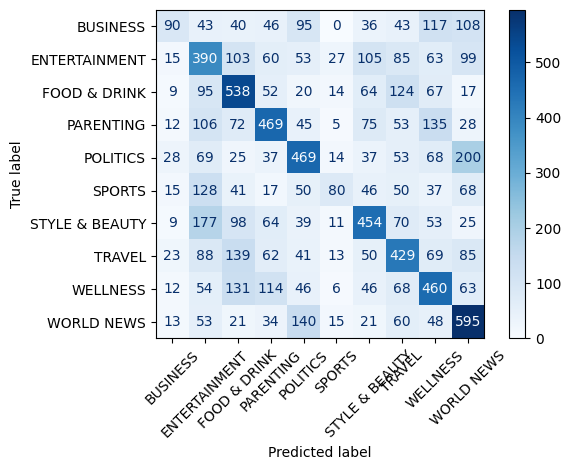


 Support Vector Machine:
Training Accuracy: 0.4252063179756244
Testing Accuracy: 0.4194993988414034

Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.48      0.06      0.11       618
 ENTERTAINMENT       0.33      0.32      0.32      1000
  FOOD & DRINK       0.41      0.58      0.48      1000
     PARENTING       0.47      0.51      0.49      1000
      POLITICS       0.46      0.47      0.46      1000
        SPORTS       0.51      0.10      0.16       532
STYLE & BEAUTY       0.45      0.46      0.45      1000
        TRAVEL       0.40      0.41      0.40       999
      WELLNESS       0.40      0.43      0.42      1000
    WORLD NEWS       0.42      0.58      0.49      1000

      accuracy                           0.42      9149
     macro avg       0.43      0.39      0.38      9149
  weighted avg       0.43      0.42      0.40      9149



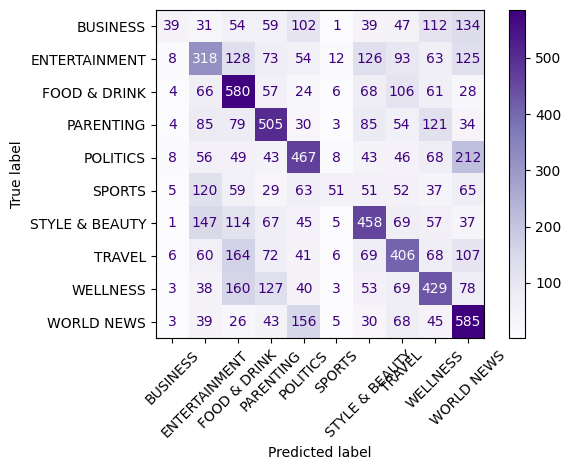


 Multinomial Naive Bayes (TF-IDF):
Training Accuracy: 0.7014537902388369
Testing Accuracy: 0.6291397966990928

Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.71      0.38      0.50       618
 ENTERTAINMENT       0.58      0.54      0.56      1000
  FOOD & DRINK       0.68      0.74      0.71      1000
     PARENTING       0.52      0.68      0.59      1000
      POLITICS       0.63      0.61      0.62      1000
        SPORTS       0.78      0.36      0.49       532
STYLE & BEAUTY       0.71      0.69      0.70      1000
        TRAVEL       0.64      0.66      0.65       999
      WELLNESS       0.56      0.66      0.61      1000
    WORLD NEWS       0.67      0.74      0.71      1000

      accuracy                           0.63      9149
     macro avg       0.65      0.61      0.61      9149
  weighted avg       0.64      0.63      0.62      9149



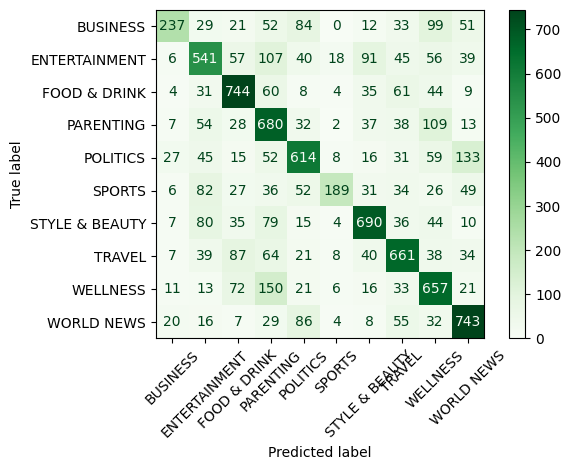

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Logistic Regression (Word2Vec) ---
print(" Logistic Regression:")
y_pred_lr = lr.predict(X_train_w2v)
print("Training Accuracy:", accuracy_score(y_train_w2v, y_pred_lr))

y_pred_lr_test = lr.predict(X_test_w2v)
print("Testing Accuracy:", accuracy_score(y_test_w2v, y_pred_lr_test))
print("\nClassification Report:\n", classification_report(y_test_w2v, y_pred_lr_test))

cm_lr = confusion_matrix(y_test_w2v, y_pred_lr_test, labels=lr.classes_)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr.classes_)
disp_lr.plot(cmap='Blues')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- SVM (Word2Vec) ---
print("\n Support Vector Machine:")
y_pred_svm = svm.predict(X_train_w2v)
print("Training Accuracy:", accuracy_score(y_train_w2v, y_pred_svm))

y_pred_svm_test = svm.predict(X_test_w2v)
print("Testing Accuracy:", accuracy_score(y_test_w2v, y_pred_svm_test))
print("\nClassification Report:\n", classification_report(y_test_w2v, y_pred_svm_test))

cm_svm = confusion_matrix(y_test_w2v, y_pred_svm_test, labels=svm.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm.classes_)
disp_svm.plot(cmap='Purples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Naive Bayes (TF-IDF) ---
print("\n Multinomial Naive Bayes (TF-IDF):")
y_pred_nb = nb.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_pred_nb))

y_pred_nb_test = nb.predict(X_test)
print("Testing Accuracy:", accuracy_score(y_test, y_pred_nb_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb_test))

cm_nb = confusion_matrix(y_test, y_pred_nb_test, labels=nb.classes_)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb.classes_)
disp_nb.plot(cmap='Greens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Bar Chart: Accuracy & F1-score Comparison

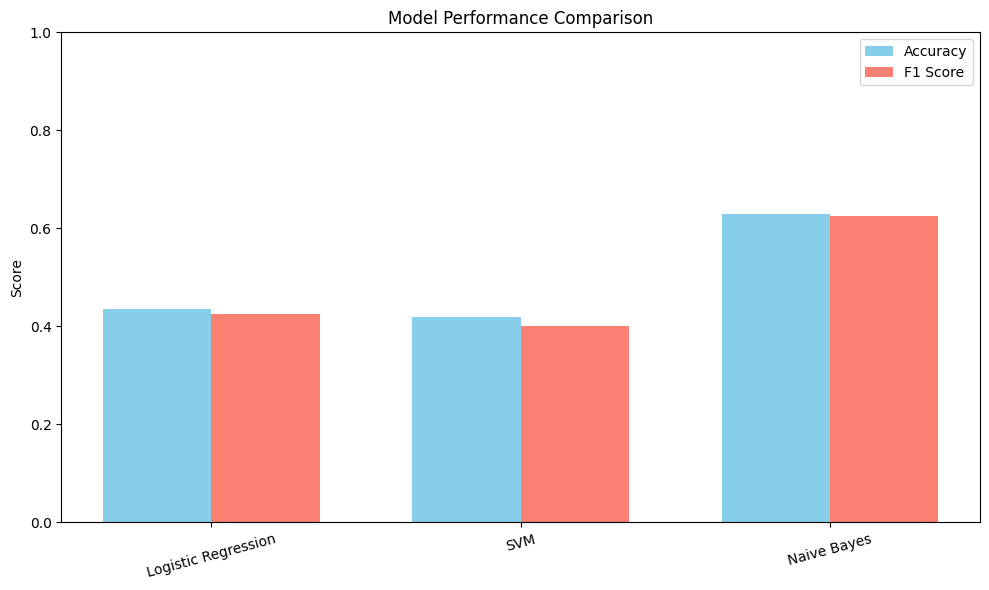

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Calculate metrics
accuracy_lr = accuracy_score(y_test_w2v, y_pred_lr_test)
f1_lr = f1_score(y_test_w2v, y_pred_lr_test, average='weighted')

accuracy_svm = accuracy_score(y_test_w2v, y_pred_svm_test)
f1_svm = f1_score(y_test_w2v, y_pred_svm_test, average='weighted')

accuracy_nb = accuracy_score(y_test, y_pred_nb_test)
f1_nb = f1_score(y_test, y_pred_nb_test, average='weighted')

# Prepare for plot
models = ['Logistic Regression', 'SVM', 'Naive Bayes']
accuracy = [accuracy_lr, accuracy_svm, accuracy_nb]
f1_scores = [f1_lr, f1_svm, f1_nb]

x = np.arange(len(models))
width = 0.35

# Plot
plt.figure(figsize=(10,6))
plt.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='salmon')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models, rotation=15)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


Metric Summary


In [ ]:
print(" Model Performance Summary")
print("-" * 45)
print(f"{'Model':<25}{'Accuracy':<10}{'F1-score':<10}")
print(f"{'Logistic Regression':<25}{accuracy_score(y_test_w2v, y_pred_lr_test):<10.4f}{f1_score(y_test_w2v, y_pred_lr_test, average='weighted'):<10.4f}")
print(f"{'SVM':<25}{accuracy_score(y_test_w2v, y_pred_svm_test):<10.4f}{f1_score(y_test_w2v, y_pred_svm_test, average='weighted'):<10.4f}")
print(f"{'Naive Bayes (TF-IDF)':<25}{accuracy_score(y_test, y_pred_nb_test):<10.4f}{f1_score(y_test, y_pred_nb_test, average='weighted'):<10.4f}")


 Model Performance Summary
---------------------------------------------
Model                    Accuracy  F1-score  
Logistic Regression      0.4344    0.4248    
SVM                      0.4195    0.4009    
Naive Bayes (TF-IDF)     0.6291    0.6247    


## prediction

In [ ]:
def preprocess(text):

    return text.lower()

# New article
new_article = "The government has announced a new policy on data privacy regulations."
new_processed = preprocess(new_article)

# Word2Vec vectorization
import numpy as np
words = new_processed.split()
word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
if word_vectors:
    article_vector = np.mean(word_vectors, axis=0).reshape(1, -1)
    article_vector_scaled = scaler.transform(article_vector)
    prediction = svm.predict(article_vector_scaled)
    print("Predicted Category:", prediction[0])
else:
    print("No known words found in the article.")


Predicted Category: POLITICS


prdeiction function for naive bayes

In [ ]:
def predict_category_nb(article_text, tfidf_vectorizer, nb_model):

    # Preprocess (same steps used during training)
    article_text = article_text.lower()

    # Transform with the fitted TF-IDF vectorizer
    X_input = tfidf_vectorizer.transform([article_text])

    # Predict
    prediction = nb_model.predict(X_input)[0]

    return prediction


In [ ]:
new_article = "The new iPhone was launched with AI-powered features and a sleek design."
predicted_category = predict_category_nb(new_article, tfidf, nb)
print("Predicted Category:", predicted_category)

Predicted Category: STYLE & BEAUTY
